In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

Download Model from Tensorflow website :

[http://download.tensorflow.org/models/object_detection/mask_rcnn_inception_v2_coco_2018_01_28.tar.gz](http://download.tensorflow.org/models/object_detection/mask_rcnn_inception_v2_coco_2018_01_28.tar.gz)

In [2]:
textGraph = "model/tensorflow/mask_rcnn_inception_v2_coco_2018_01_28.pbtxt"
modelWeights = "model/tensorflow/mask_rcnn_frozen_inference_graph.pb"

# Load the network
net = cv2.dnn.readNetFromTensorflow(modelWeights, textGraph);

In [3]:
# Initialize the parameters
confThreshold = 0.5  # Confidence threshold
maskThreshold = 0.3  # Mask threshold

In [4]:
# Draw the predicted bounding box, colorize and show the mask on the image
def drawBox(frame, classId, conf, left, top, right, bottom, classMask):
    # Draw a bounding box.
    cv2.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
    
    # Print a label of class.
    label = '%.2f' % conf
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)
    
    # Display the label at the top of the bounding box
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (255, 255, 255), cv2.FILLED)
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1)

    # Resize the mask, threshold, color and apply it on the image
    classMask = cv2.resize(classMask, (right - left + 1, bottom - top + 1))
    mask = (classMask > maskThreshold)
    roi = frame[top:bottom+1, left:right+1][mask]

    # color = colors[classId%len(colors)]
    # Comment the above line and uncomment the two lines below to generate different instance colors
    colorIndex = random.randint(0, len(colors)-1)
    color = colors[colorIndex]

    frame[top:bottom+1, left:right+1][mask] = ([0.3*color[0], 0.3*color[1], 0.3*color[2]] + 0.7 * roi).astype(np.uint8)

    # Draw the contours on the image
    mask = mask.astype(np.uint8)
    contours, hierarchy = cv2.findContours(mask,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(frame[top:bottom+1, left:right+1], contours, -1, color, 3, cv2.LINE_8, hierarchy, 100)

# For each frame, extract the bounding box and mask for each detected object
def postprocess(boxes, masks):
    # Output size of masks is NxCxHxW where
    # N - number of detected boxes
    # C - number of classes (excluding background)
    # HxW - segmentation shape
    numClasses = masks.shape[1]
    numDetections = boxes.shape[2]

    frameH = frame.shape[0]
    frameW = frame.shape[1]

    for i in range(numDetections):
        box = boxes[0, 0, i]
        mask = masks[i]
        score = box[2]
        if score > confThreshold:
            classId = int(box[1])
            
            # Extract the bounding box
            left = int(frameW * box[3])
            top = int(frameH * box[4])
            right = int(frameW * box[5])
            bottom = int(frameH * box[6])
            
            left = max(0, min(left, frameW - 1))
            top = max(0, min(top, frameH - 1))
            right = max(0, min(right, frameW - 1))
            bottom = max(0, min(bottom, frameH - 1))
            
            # Extract the mask for the object
            classMask = mask[classId]

            # Draw bounding box, colorize and show the mask on the image
            drawBox(frame, classId, score, left, top, right, bottom, classMask)


In [5]:
# Load names of classes
classesFile = "model/tensorflow/mscoco_labels.names";
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

In [6]:
classes

['person',
 'bicycle',
 'car',
 'motorcycle',
 'airplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 '',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 '',
 'backpack',
 'umbrella',
 '',
 '',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 '',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'couch',
 'potted plant',
 'bed',
 '',
 'dining table',
 '',
 '',
 'toilet',
 '',
 'tv',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 '',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

In [7]:
# Load the classes
colorsFile = "colors.txt";
with open(colorsFile, 'rt') as f:
    colorsStr = f.read().rstrip('\n').split('\n')
colors = [] #[0,0,0]
for i in range(len(colorsStr)):
    rgb = colorsStr[i].split(' ')
    color = np.array([float(rgb[0]), float(rgb[1]), float(rgb[2])])
    colors.append(color)
colors

[array([  0., 255.,   0.]),
 array([  0.,   0., 255.]),
 array([255.,   0.,   0.]),
 array([  0., 255., 255.]),
 array([255., 255.,   0.]),
 array([255.,   0., 255.]),
 array([ 80.,  70., 180.]),
 array([250.,  80., 190.]),
 array([245., 145.,  50.]),
 array([ 70., 150., 250.]),
 array([ 50., 190., 190.])]

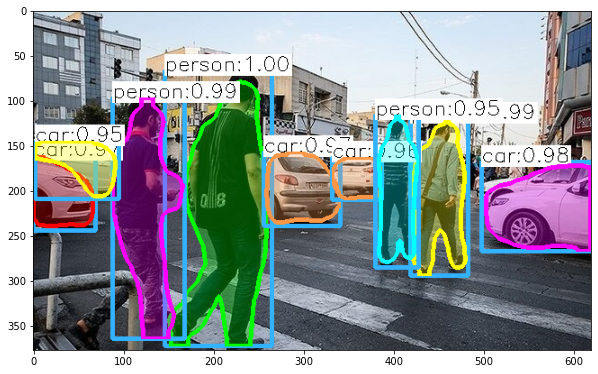

In [8]:
import random

frame= cv2.imread("images/pedestrian.jpg")

# Create a 4D blob from a frame.
blob = cv2.dnn.blobFromImage(frame, swapRB=True, crop=False)

# Set the input to the network
net.setInput(blob)

# Run the forward pass to get output from the output layers
boxes, masks = net.forward(['detection_out_final', 'detection_masks'])

# Extract the bounding box and mask for each of the detected objects
postprocess(boxes, masks)

plt.figure(figsize=[10,10])
plt.imshow(frame[...,::-1])